In [39]:
# all the import statements

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
Ba

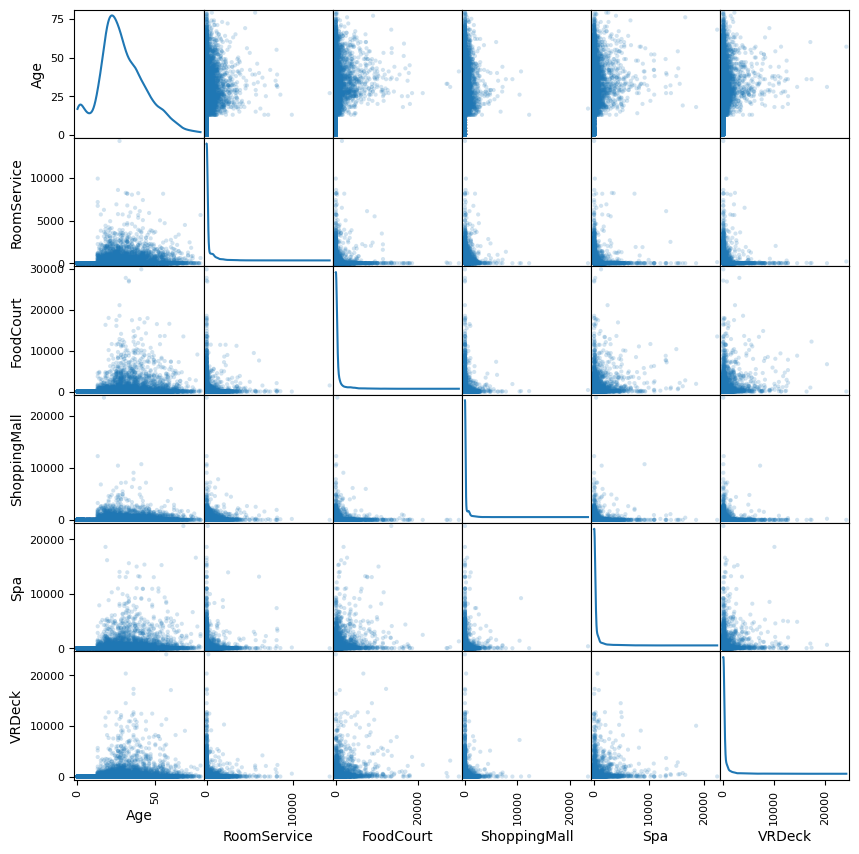

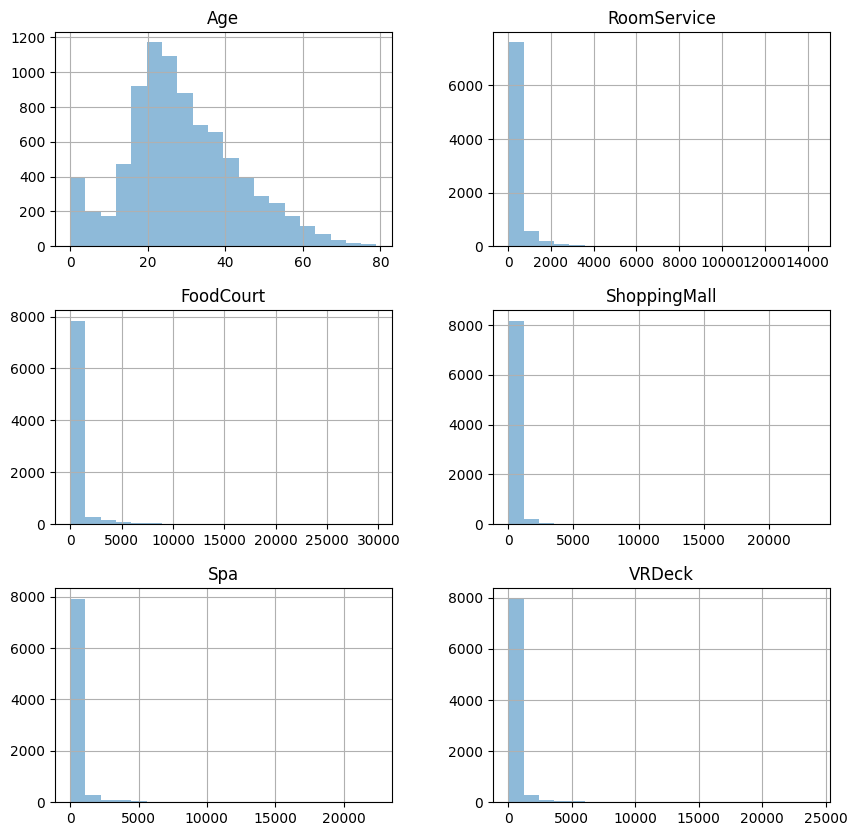

In [40]:
def load_data():
    train_data = pd.read_csv('train.csv')
    return train_data

train_data = load_data()
print(train_data.head())
training_data = train_data.drop(columns=["Transported"])
target_label = train_data["Transported"]
target_attributes = ["Transported"]

num_attributes = training_data.select_dtypes(include=[np.number]).columns.tolist()
cat_attributes = training_data.select_dtypes(exclude=[np.number]).columns.tolist()
items_to_remove = ["PassengerId", "Name", "Cabin","CryoSleep","VIP"]
new_cat_attributes = [ x for x in cat_attributes if x not in items_to_remove]
bool_attributes = ["CryoSleep", "VIP"]

scat_matrix = scatter_matrix(training_data,figsize=(10,10),grid=True, diagonal='kde', alpha=0.2)
training_data.hist(figsize=(10,10), grid=True, bins=20, alpha=0.5)
print("Basic processing completed.")

In [41]:
training_data = shuffle(training_data, random_state=42)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('select_k_best', SelectKBest(k=10))  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_pipeline = Pipeline([  
    ('imputer', SimpleImputer(strategy='constant', fill_value=False)),])

pre_processing = ColumnTransformer(
    transformers=[
        ('num', num_pipeline,num_attributes),
        ('cat', cat_pipeline,new_cat_attributes),
        ('bool', bool_pipeline,bool_attributes)
    ]
)

In [42]:
def compute_class_weights(train_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Transported"]),y=train_data["Transported"])
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")
    return class_weight_dict

class_weights = compute_class_weights(train_data)

Class weights computed


In [43]:
sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,class_weight=class_weights)

svm_clf = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=2000, max_depth=10,
                                min_samples_split=10, min_samples_leaf=2,
                                max_features='log2', bootstrap=True,ccp_alpha=0.01,
                                class_weight=class_weights, random_state=42)

model_pipeline = Pipeline([
('pre_processor', pre_processing),
('classifier', rf_clf)])

print("Model pipeline created.")    

Model pipeline created.


In [ ]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cvl_scores = cross_validate(model_pipeline, training_data, target_label, cv=5,
                            scoring=scoring, error_score="raise")
cvl_scores_df = pd.DataFrame(cvl_scores)
print(pd.DataFrame(cvl_scores_df.mean()))

/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

                             0
fit_time              0.824102
score_time            0.015547
test_accuracy         0.499138
test_precision_macro  0.249569
test_recall_macro     0.500000
test_f1_macro         0.332946


/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[0.50009808 0.49990192]
 [0.50009808 0.49990192]
 [0.50009808 0.49990192]
 ...
 [0.49992905 0.50007095]
 [0.49992905 0.50007095]
 [0.49992905 0.50007095]]


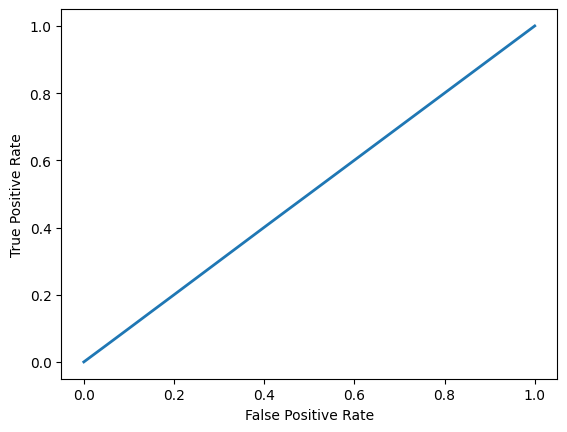

Model training and evaluation completed.


In [45]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(model_pipeline, training_data ,target_label, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(target_label, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dict = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': [0.0, 0.01, 0.1],
    'classifier__bootstrap': [True, False]
}
# Perform RandomizedSearchCV with SVC-specific parameters
random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(training_data, target_label)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

NameError: name 'train_data_target' is not defined